In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#dat = np.load("tiny_data.npz")
from gen_data_norm import gen_rhs

In [22]:
#arr = dat.items()[0][1][:100, :]
#arr = dat[0][:100, :]
#print arr

In [23]:
#plt.imshow(arr[99].reshape((25, 25, 25))[:, 10, :])
#plt.colorbar()

In [3]:
import os
from datetime import datetime
from neon.callbacks.callbacks import Callbacks, GANCostCallback
#from neon.callbacks.plotting_callbacks import GANPlotCallback
from neon.initializers import Gaussian
from neon.layers import GeneralizedGANCost, Affine, Sequential, Conv, Deconv, Dropout, Pooling, BatchNorm
from neon.layers.layer import Linear, Reshape
from neon.layers.container import GenerativeAdversarial
from neon.models.model import GAN, Model
from neon.transforms import Rectlin, Logistic, GANCost, Tanh
from neon.util.argparser import NeonArgparser
from neon.util.persist import ensure_dirs_exist
from neon.layers.layer import Dropout
from neon.data.dataiterator import ArrayIterator
from neon.optimizers import GradientDescentMomentum, RMSProp
from neon.backends import gen_backend
import numpy as np
from sklearn.cross_validation import train_test_split

DISPLAY:neon:mklEngine.so not found; falling back to cpu backend
/Users/svalleco/GAN/neon2.2/.venv2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
#X = arr.copy()
#y = np.ones(arr.shape[0])
#X[X < 1e-6] = 0
#print X[X>100]

In [26]:
#mean = np.mean(X, axis=0, keepdims=True)
#print mean
#xmax = np.amax(X)
#print xmax

In [27]:
#X -=mean
#print X

In [28]:
#plt.imshow(X[2].reshape((25, 25, 25))[:, 12, :])
#plt.colorbar()

In [4]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
X_train, y_train = gen_rhs(100)
X_test, y_test = gen_rhs(10)
X_train /= 30.0
X_train = 1- X_train
print(X_train.shape, 'X train shape')
print(y_train.shape, 'y train shape')

((100, 15625), 'X train shape')
((100,), 'y train shape')


In [5]:
gen_backend(backend='cpu', batch_size=10)
train_set = ArrayIterator(X=X_train, y=y_train, nclass=2, lshape=(1, 25, 25, 25))
valid_set = ArrayIterator(X=X_test, y=y_test, nclass=2)

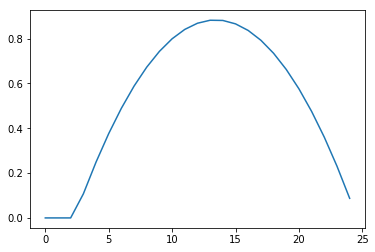

In [10]:
plt.plot(X_train[11].reshape((25, 25, 25))[12, 12, :])

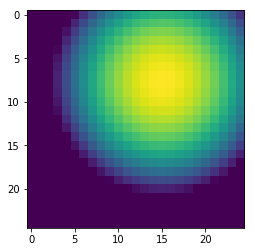

In [13]:
plt.imshow(X_train[2].reshape((25, 25, 25))[:, 12, :])

## Model.py and Callbacks.py changed

In [14]:
init = Gaussian(scale=0.01)

# discriminiator using convolution layers
lrelu = Rectlin(slope=0.1)  # leaky relu for discriminator
# sigmoid = Logistic() # sigmoid activation function
conv1 = dict(init=init, batch_norm=False, activation=lrelu, bias=init) # what's about BatchNorm Layer and batch_norm parameter?
conv2 = dict(init=init, batch_norm=False, activation=lrelu, padding=2, bias=init)
conv3 = dict(init=init, batch_norm=False, activation=lrelu, padding=1, bias=init)
D_layers = [
            Conv((5, 5, 5, 32), **conv1),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv3),
            BatchNorm(),
            Dropout(keep = 0.8),
            Pooling((2, 2, 2)),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1, init=init, bias=init, activation=Logistic())
            ]

# generator using convolution layers
init_gen = Gaussian(scale=0.01)
relu = Rectlin(slope=0)  # relu for generator
pad1 = dict(pad_h=2, pad_w=2, pad_d=2)
str1 = dict(str_h=2, str_w=2, str_d=2)
conv1 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad1, strides=str1, bias=init_gen)
pad2 = dict(pad_h=2, pad_w=2, pad_d=2)
str2 = dict(str_h=2, str_w=2, str_d=2)
conv2 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad2, strides=str2, bias=init_gen)
pad3 = dict(pad_h=0, pad_w=0, pad_d=0)
str3 = dict(str_h=1, str_w=1, str_d=1)
conv3 = dict(init=init_gen, batch_norm=False, activation=Tanh(), padding=pad3, strides=str3, bias=init_gen)
G_layers = [
            Affine(1024, init=init_gen, bias=init_gen, activation=relu),
            BatchNorm(),
            Affine(8 * 7 * 7 * 7, init=init_gen, bias=init_gen),
            Reshape((8, 7, 7, 7)),
            Deconv((6, 6, 6, 6), **conv1), #14x14x14
            BatchNorm(),
            Deconv((5, 5, 5, 6), **conv2), #27x27x27
            BatchNorm(),
            Conv((3, 3, 3, 1), **conv3)
            ]

layers = GenerativeAdversarial(generator=Sequential(G_layers, name="Generator"),
                               discriminator=Sequential(D_layers, name="Discriminator"))

# setup optimizer
optimizer = RMSProp(learning_rate=1e-3, decay_rate=0.9, epsilon=1e-8)
# optimizer = GradientDescentMomentum(learning_rate=1e-3, momentum_coef = 0.9)

# setup cost function as Binary CrossEntropy
cost = GeneralizedGANCost(costfunc=GANCost(func="modified"))

nb_epochs = 10
batch_size = 10
latent_size = 50
inb_classes = 2
nb_test = 100

# initialize model
noise_dim = (latent_size)
gan = GAN(layers=layers, noise_dim=noise_dim)

# configure callbacks
callbacks = Callbacks(gan, eval_set=valid_set)
callbacks.add_callback(GANCostCallback())
#callbacks.add_save_best_state_callback("./best_state.pkl")

# run fit
gan.fit(train_set, num_epochs=nb_epochs, optimizer=optimizer,
        cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████|   10/10   batches, 1.76490092 cost, 115.89s]
Epoch 1   [Train |████████████████████|   10/10   batches, 1.43650436 cost, 131.71s]
Epoch 2   [Train |████████████████████|   10/10   batches, 1.43341577 cost, 140.65s]
Epoch 3   [Train |████████████████████|   10/10   batches, 1.44362187 cost, 133.40s]
Epoch 4   [Train |████████████████████|   10/10   batches, 1.43465495 cost, 130.93s]
Epoch 5   [Train |████████████████████|   10/10   batches, 1.43578494 cost, 132.27s]
Epoch 6   [Train |████████████████████|   10/10   batches, 1.42927504 cost, 150.40s]
Epoch 7   [Train |████████████████████|   10/10   batches, 1.45106161 cost, 133.35s]
Epoch 8   [Train |████████████████████|   10/10   batches, 1.42225754 cost, 135.42s]
Epoch 9   [Train |████████████████████|   10/10   batches, 1.43066669 cost, 125.10s]


## Original neon

In [28]:
init = Gaussian(scale=0.01)

# discriminiator using convolution layers
lrelu = Rectlin(slope=0.1)  # leaky relu for discriminator
# sigmoid = Logistic() # sigmoid activation function
conv1 = dict(init=init, batch_norm=False, activation=lrelu, bias=init) # what's about BatchNorm Layer and batch_norm parameter?
conv2 = dict(init=init, batch_norm=False, activation=lrelu, padding=2, bias=init)
conv3 = dict(init=init, batch_norm=False, activation=lrelu, padding=1, bias=init)
D_layers = [
            Conv((5, 5, 5, 32), **conv1),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv2),
            BatchNorm(),
            Dropout(keep = 0.8),
            Conv((5, 5, 5, 8), **conv3),
            BatchNorm(),
            Dropout(keep = 0.8),
            Pooling((2, 2, 2)),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1024, init=init, activation=lrelu),
            BatchNorm(),
            Affine(1, init=init, bias=init, activation=Logistic())
            ]

# generator using convolution layers
init_gen = Gaussian(scale=0.01)
relu = Rectlin(slope=0)  # relu for generator
pad1 = dict(pad_h=2, pad_w=2, pad_d=2)
str1 = dict(str_h=2, str_w=2, str_d=2)
conv1 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad1, strides=str1, bias=init_gen)
pad2 = dict(pad_h=2, pad_w=2, pad_d=2)
str2 = dict(str_h=2, str_w=2, str_d=2)
conv2 = dict(init=init_gen, batch_norm=False, activation=lrelu, padding=pad2, strides=str2, bias=init_gen)
pad3 = dict(pad_h=0, pad_w=0, pad_d=0)
str3 = dict(str_h=1, str_w=1, str_d=1)
conv3 = dict(init=init_gen, batch_norm=False, activation=Tanh(), padding=pad3, strides=str3, bias=init_gen)
G_layers = [
            Affine(1024, init=init_gen, bias=init_gen, activation=relu),
            BatchNorm(),
            Affine(8 * 7 * 7 * 7, init=init_gen, bias=init_gen),
            Reshape((8, 7, 7, 7)),
            Deconv((6, 6, 6, 6), **conv1), #14x14x14
            BatchNorm(),
            Deconv((5, 5, 5, 6), **conv2), #27x27x27
            BatchNorm(),
            Conv((3, 3, 3, 1), **conv3)
            ]

layers = GenerativeAdversarial(generator=Sequential(G_layers, name="Generator"),
                               discriminator=Sequential(D_layers, name="Discriminator"))

# setup optimizer
optimizer = RMSProp(learning_rate=1e-3, decay_rate=0.9, epsilon=1e-8)
# optimizer = GradientDescentMomentum(learning_rate=1e-3, momentum_coef = 0.9)

# setup cost function as Binary CrossEntropy
cost = GeneralizedGANCost(costfunc=GANCost(func="modified"))

nb_epochs = 10
batch_size = 10
latent_size = 50
inb_classes = 2
nb_test = 100

# initialize model
noise_dim = (latent_size)
gan = GAN(layers=layers, noise_dim=noise_dim)

# configure callbacks
callbacks = Callbacks(gan, eval_set=valid_set)
callbacks.add_callback(GANCostCallback())
#callbacks.add_save_best_state_callback("./best_state.pkl")

# run fit
gan.fit(train_set, num_epochs=nb_epochs, optimizer=optimizer,
        cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████|    9/9    batches, 2.04 cost, 148.17s]
Epoch 1   [Train |████████████████████|    9/9    batches, 1.41 cost, 162.09s]
Epoch 2   [Train |████████████████████|    9/9    batches, 1.45 cost, 155.64s]
Epoch 3   [Train |████████████████████|    9/9    batches, 1.43 cost, 176.33s]
Epoch 4   [Train |████████████████████|    9/9    batches, 1.45 cost, 158.76s]
Epoch 5   [Train |████████████████████|    9/9    batches, 1.44 cost, 158.20s]
Epoch 6   [Train |████████████████████|    9/9    batches, 1.44 cost, 153.00s]
Epoch 7   [Train |████████████████████|    9/9    batches, 1.43 cost, 167.29s]
Epoch 8   [Train |████████████████████|    9/9    batches, 1.43 cost, 169.24s]
Epoch 9   [Train |████████████████████|    9/9    batches, 1.44 cost, 169.72s]


In [29]:
test1 = my_generator.get_outputs(inference_set)
test1 += mean

test1 =  test1.reshape((100, 25, 25, 25))

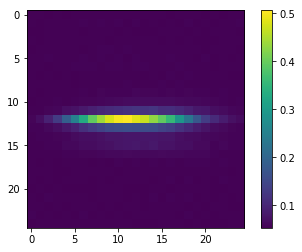

In [30]:
plt.imshow(test1[10, :, 12, :])
plt.colorbar()

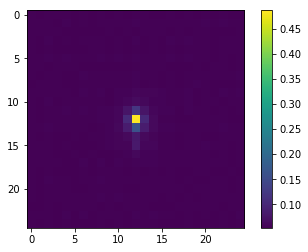

In [32]:
plt.imshow(test1[12, :, :, 12])
plt.colorbar()

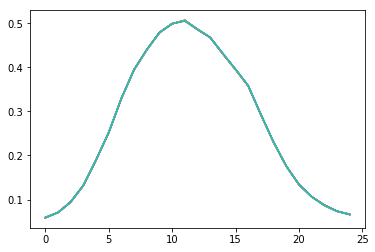

In [35]:
for i in range(10):
    plt.plot(test1[i, 12, 12, :])
plt.savefig('output_distr.pdf')

In [15]:
x_new = np.random.rand(100, latent_size)
inference_set = ArrayIterator(x_new, None, nclass=2, lshape=(latent_size))
my_generator = Model(gan.layers.generator)


In [16]:
test = my_generator.get_outputs(inference_set)
test += mean

test =  test.reshape((100, 25, 25, 25))

NameError: name 'mean' is not defined

In [18]:
plt.imshow(test[0, :, 12, :])
plt.colorbar()

IndexError: too many indices for array

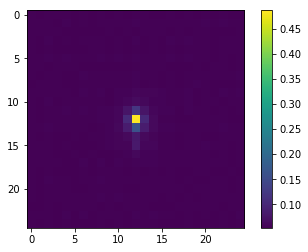

In [24]:
plt.imshow(test[12, :, :, 12])
plt.colorbar()

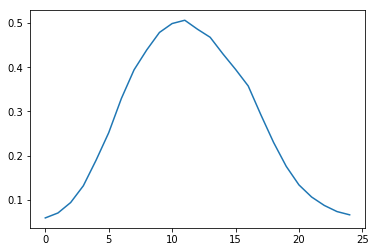

In [25]:
plt.plot(test[0, 12, 12, : ])
plt.show()

In [26]:
test[0, :, 12, :]

array([[ 0.05530309,  0.05599188,  0.05553356,  0.05526203,  0.05513674,
         0.05583674,  0.05655745,  0.05658168,  0.05573881,  0.05598341,
         0.05595049,  0.0559646 ,  0.05570387,  0.05540949,  0.05648412,
         0.05522768,  0.05500522,  0.05541708,  0.05547779,  0.0562312 ,
         0.05506795,  0.0554008 ,  0.05501239,  0.05606633,  0.05531304],
       [ 0.05640053,  0.054566  ,  0.05635238,  0.05623753,  0.05740398,
         0.05658709,  0.05819311,  0.05535856,  0.05742246,  0.05514337,
         0.05690914,  0.05524942,  0.05760251,  0.05512868,  0.05575248,
         0.0551367 ,  0.05597888,  0.05493033,  0.05718162,  0.0550096 ,
         0.05552285,  0.05498891,  0.0556716 ,  0.05567972,  0.05666146],
       [ 0.05529277,  0.05503116,  0.05543863,  0.05552905,  0.05529863,
         0.05594195,  0.05472383,  0.05452052,  0.05523501,  0.05522322,
         0.0552465 ,  0.05568696,  0.05485205,  0.0549282 ,  0.05342441,
         0.05583756,  0.05611169,  0.05585293,  0